# Imports and Setup

Bagian ini memuat:
- Import library utama
- Konfigurasi untuk **PERSONALIZED forecasting** (1 model per user)
- Utility untuk evaluasi, tuning threshold, dan ringkasan per-user


In [1]:
import os
os.environ["PYTHONWARNINGS"] = "ignore"

import warnings
warnings.simplefilter("ignore")

import numpy as np
import pandas as pd
from pathlib import Path
import joblib

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import ParameterGrid

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, ExtraTreesClassifier,
    HistGradientBoostingClassifier,
    GradientBoostingClassifier, AdaBoostClassifier,
    BaggingClassifier
)
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

# =============================================================================
# 0) CONFIG
# =============================================================================
CANDIDATE_PATHS = [
    Path("../datasets/stress_forecast.csv"),
]
DATA_PATH = next((p for p in CANDIDATE_PATHS if p.exists()), None)
if DATA_PATH is None:
    raise FileNotFoundError("stress_forecast.csv not found. Check CANDIDATE_PATHS / DATA_PATH.")

MODEL_OUT = Path("../models/personalized_forecast.joblib")

DATE_COL   = "date"
USER_COL   = "userID"
TARGET_COL = "stressLevel"  # 0..2

WINDOW   = 3
TEST_LEN = 12

VAL_WINDOWS = [(10, 20), (15, 25)]
THRESHOLDS  = np.linspace(0.05, 0.95, 19)

RANDOM_STATE = 26

# Personalized: default = False (no semi-global/global)
USE_USER_ID_FEATURE = False

# Threshold tuning:
# - True  => tune threshold per user (fair: uses only that user's CV folds)
# - False => tune one global threshold pooled across users
TUNE_THRESHOLD_PER_USER = True

# Print per-user details for baselines and selected best model
PRINT_PER_USER_DETAILS = True


# =============================================================================
# Print helpers
# =============================================================================
def kv(k, v):
    print(f"{k:<20}: {v}")

def safe_class_counts(y):
    y = np.asarray(y).astype(int)
    return {0: int((y == 0).sum()), 1: int((y == 1).sum())}

def print_per_user_breakdown(title, per_user_records, thr_info=None):
    print(f"\n{title}")
    for r in per_user_records:
        uid = r["uid"]
        y = np.asarray(r["y"]).astype(int)
        pred = np.asarray(r["pred"]).astype(int)
        acc = float(accuracy_score(y, pred))
        f1  = float(f1_score(y, pred, zero_division=0))
        dist = safe_class_counts(y)

        extra = ""
        if thr_info is not None:
            if isinstance(thr_info, dict) and uid in thr_info:
                extra = f" | thr={float(thr_info[uid]):.2f}"
            elif isinstance(thr_info, (float, int)):
                extra = f" | thr={float(thr_info):.2f}"

        print(f"uid={uid} | n={len(y):<3} | dist={dist} | acc={acc:.4f} | f1={f1:.4f}{extra}")


# =============================================================================
# Core helpers
# =============================================================================
def eval_bin(y_true, y_pred):
    return {
        "acc": float(accuracy_score(y_true, y_pred)),
        "f1":  float(f1_score(y_true, y_pred, zero_division=0)),
    }

def tune_thr_from_proba(y_true, p_high, thresholds=THRESHOLDS):
    best_thr, best_f1 = None, -1.0
    for thr in thresholds:
        pred = (p_high >= thr).astype(int)
        f1 = float(f1_score(y_true, pred, zero_division=0))
        if f1 > best_f1:
            best_f1, best_thr = f1, thr
    return float(best_thr), float(best_f1)

def per_user_macro_metrics(per_user_records):
    accs, f1s = [], []
    for r in per_user_records:
        accs.append(accuracy_score(r["y"], r["pred"]))
        f1s.append(f1_score(r["y"], r["pred"], zero_division=0))
    return float(np.mean(accs)), float(np.mean(f1s))

def cv_folds_user(tp_df):
    folds = []
    for (v0, v1) in VAL_WINDOWS:
        if len(tp_df) < v1:
            continue
        tr = tp_df.iloc[:v0].copy()
        va = tp_df.iloc[v0:v1].copy()
        folds.append((tr, va))
    return folds

def min_class_count(y):
    vc = pd.Series(np.asarray(y)).value_counts()
    if len(vc) < 2:
        return 0
    return int(vc.min())


# Load and Explore Dataset

Bagian ini mencakup:
- Load dataset
- Validasi kolom wajib
- Parsing `date` dan sorting time-series per user
- Validasi range target `stressLevel` (0–2)


In [2]:
# LOAD DATA
df = pd.read_csv(DATA_PATH)

for required_col in [DATE_COL, USER_COL, TARGET_COL]:
    if required_col not in df.columns:
        raise KeyError(f"Required column '{required_col}' not found in dataset.")

df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="raise")
df = df.sort_values([USER_COL, DATE_COL]).reset_index(drop=True)

if not df[TARGET_COL].dropna().between(0, 2).all():
    raise ValueError(f"'{TARGET_COL}' must be within range 0..2")

kv("DATA_PATH", str(DATA_PATH))
kv("ROWS_RAW", len(df))
kv("USERS_RAW", df[USER_COL].nunique())
kv("DATE_RANGE_RAW", f"{df[DATE_COL].min().date()} -> {df[DATE_COL].max().date()}")

print("\nHEAD:")
display(df.head())


DATA_PATH           : ..\datasets\stress_forecast.csv
ROWS_RAW            : 300
USERS_RAW           : 5
DATE_RANGE_RAW      : 2025-11-21 -> 2026-01-19

HEAD:


,stressLevelID,userID,date,stressLevel,GPA,extracurricularHourPerDay,physicalActivityHourPerDay,sleepHourPerDay,studyHourPerDay,socialHourPerDay,emoji,createdAt
0,2,1,2025-11-21,1,3.82,0.0,0.5,7.0,7.0,2.0,1,2025-11-21 21:12:00
1,7,1,2025-11-22,0,3.82,0.0,1.0,9.0,2.0,5.0,2,2025-11-22 20:07:00
2,12,1,2025-11-23,0,3.82,0.0,3.0,9.0,1.0,6.0,1,2025-11-23 22:18:00
3,17,1,2025-11-24,1,3.82,0.0,0.5,8.0,7.0,5.0,3,2025-11-24 19:55:00
4,22,1,2025-11-25,1,3.82,0.0,1.0,7.0,7.0,4.0,3,2025-11-25 21:40:00


# Exploratory Data Analysis (EDA)

Ringkasan cepat:
- Distribusi `stressLevel` (0–2)
- Jumlah baris per user (indikasi kecukupan data untuk split & CV)


TARGET_DIST_0_2     : {0: 124, 1: 91, 2: 85}


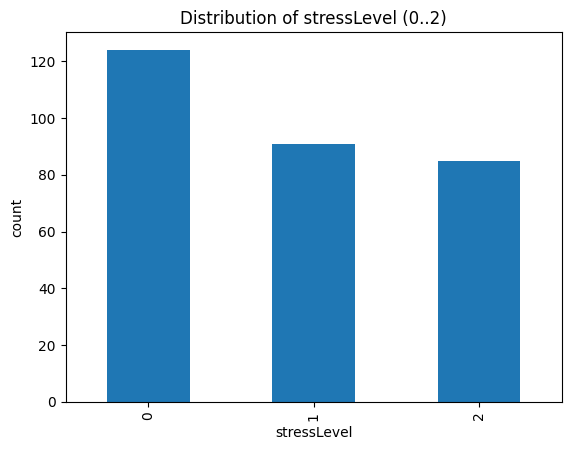

ROWS_PER_USER       : {1: 60, 2: 60, 3: 60, 4: 60, 5: 60}


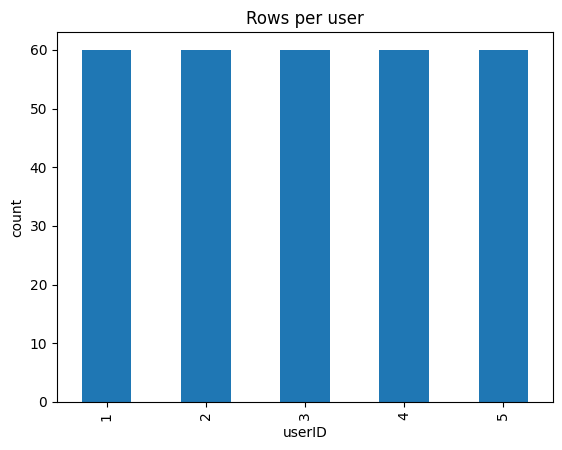

In [3]:

# EDA: target distribution (0..2)
target_counts = df[TARGET_COL].value_counts().sort_index()
kv("TARGET_DIST_0_2", target_counts.to_dict())

plt.figure()
target_counts.plot(kind="bar")
plt.title(f"Distribution of {TARGET_COL} (0..2)")
plt.xlabel(TARGET_COL)
plt.ylabel("count")
plt.show()

# EDA: rows per user
rows_per_user = df[USER_COL].value_counts().sort_index()
kv("ROWS_PER_USER", rows_per_user.to_dict())

plt.figure()
rows_per_user.plot(kind="bar")
plt.title("Rows per user")
plt.xlabel(USER_COL)
plt.ylabel("count")
plt.show()


# Data Preprocessing

Bagian ini melakukan **feature engineering tanpa leakage**:
- Fitur kalender: `dow`, `is_weekend`
- Fitur lag target: `lag_sp_1..lag_sp_WINDOW`
- Rolling stats dari history yang berakhir di `t-1`

Transformasi label:
- `y_bin = 1` jika `stressLevel >= 1`
- `y_bin = 0` jika `stressLevel == 0`


In [4]:
# FEATURE ENGINEERING (NO-LEAK)
rows = []
for uid, g in df.groupby(USER_COL):
    g = g.sort_values(DATE_COL).reset_index(drop=True)

    g["dow"] = g[DATE_COL].dt.dayofweek.astype(int)
    g["is_weekend"] = (g["dow"] >= 5).astype(int)

    for k in range(1, WINDOW + 1):
        g[f"lag_sp_{k}"] = g[TARGET_COL].shift(k)

    sp_shift = g[TARGET_COL].shift(1)

    g["sp_mean"] = sp_shift.rolling(WINDOW).mean()
    g["sp_std"]  = sp_shift.rolling(WINDOW).std().fillna(0.0)
    g["sp_min"]  = sp_shift.rolling(WINDOW).min()
    g["sp_max"]  = sp_shift.rolling(WINDOW).max()

    g["count_high"] = (sp_shift >= 1).rolling(WINDOW).sum()
    g["count_low"]  = (sp_shift == 0).rolling(WINDOW).sum()

    high = (sp_shift >= 1).astype(int).fillna(0).astype(int).tolist()
    streak, cur = [], 0
    for v in high:
        cur = cur + 1 if v == 1 else 0
        streak.append(cur)
    g["streak_high"] = streak

    diff = (sp_shift != sp_shift.shift(1)).astype(int)
    g["transitions"] = diff.rolling(WINDOW).sum()

    rows.append(g)

feat = pd.concat(rows, ignore_index=True)

# Binary labeling: y_bin = 1 if pred>=1 else 0
feat["y_bin"] = (feat[TARGET_COL] >= 1).astype(int)

feature_cols = (
    ["dow", "is_weekend"]
    + [f"lag_sp_{k}" for k in range(1, WINDOW + 1)]
    + [
        "sp_mean", "sp_std", "sp_min", "sp_max",
        "count_high", "count_low",
        "streak_high", "transitions",
    ]
)
if USE_USER_ID_FEATURE:
    feature_cols = [USER_COL] + feature_cols

feat = feat.dropna(subset=feature_cols + ["y_bin"]).reset_index(drop=True)
users = sorted(feat[USER_COL].unique().tolist())

kv("ROWS_FEAT", len(feat))
kv("USERS", users)
kv("DATE_RANGE_FEAT", f"{feat[DATE_COL].min().date()} -> {feat[DATE_COL].max().date()}")
kv("WINDOW", WINDOW)
kv("TEST_LEN", TEST_LEN)
kv("FEATURES_COUNT", len(feature_cols))
kv("USE_USER_ID_FEATURE", USE_USER_ID_FEATURE)
kv("BINARY_DIST", feat["y_bin"].value_counts().to_dict())
kv("VAL_WINDOWS", VAL_WINDOWS)
kv("TUNE_THRESHOLD_PER_USER", TUNE_THRESHOLD_PER_USER)

display(feat[[USER_COL, DATE_COL, TARGET_COL, "y_bin"] + feature_cols].head())


ROWS_FEAT           : 285
USERS               : [1, 2, 3, 4, 5]
DATE_RANGE_FEAT     : 2025-11-24 -> 2026-01-19
WINDOW              : 3
TEST_LEN            : 12
FEATURES_COUNT      : 13
USE_USER_ID_FEATURE : False
BINARY_DIST         : {1: 171, 0: 114}
VAL_WINDOWS         : [(10, 20), (15, 25)]
TUNE_THRESHOLD_PER_USER: True


,userID,date,stressLevel,y_bin,dow,is_weekend,lag_sp_1,lag_sp_2,lag_sp_3,sp_mean,sp_std,sp_min,sp_max,count_high,count_low,streak_high,transitions
0,1,2025-11-24,1,1,0,0,0.0,0.0,1.0,0.333333,0.57735,0.0,1.0,1.0,2.0,0,2.0
1,1,2025-11-25,1,1,1,0,1.0,0.0,0.0,0.333333,0.57735,0.0,1.0,1.0,2.0,1,2.0
2,1,2025-11-26,1,1,2,0,1.0,1.0,0.0,0.666667,0.57735,0.0,1.0,2.0,1.0,2,1.0
3,1,2025-11-27,1,1,3,0,1.0,1.0,1.0,1.000000,0.00000,1.0,1.0,3.0,0.0,3,1.0
4,1,2025-11-28,1,1,4,0,1.0,1.0,1.0,1.000000,0.00000,1.0,1.0,3.0,0.0,4,0.0


# Model Training and Evaluation

Cakupan bagian ini:
- Split time-based per user (TEST = last `TEST_LEN`)
- Baseline L1: Persistence
- Baseline L2: Markov per-user + threshold tuning (pooled CV)
- Kandidat model ML per user (tanpa userID sebagai fitur)
- SVM calibrated dengan cv adaptif (SAFE)
- Leaderboard + seleksi model terbaik vs baseline
- Simpan artifact ke file `.joblib`


In [5]:
# SPLIT PER USER (TIME-BASED)
per_user = {}
split_rows = []

for uid in users:
    g = feat[feat[USER_COL] == uid].sort_values(DATE_COL).reset_index(drop=True)
    n = len(g)
    test_start = n - TEST_LEN
    if test_start <= 10:
        raise ValueError(f"User {uid}: insufficient rows for split (n={n}, TEST_LEN={TEST_LEN}).")

    tp = g.iloc[:test_start].copy()
    te = g.iloc[test_start:].copy()

    per_user[uid] = {"train_pool": tp, "test": te}

    split_rows.append({
        "uid": uid,
        "n_total": n,
        "n_train_pool": len(tp),
        "n_test": len(te),
        "train_pool_dist": safe_class_counts(tp["y_bin"].values),
        "test_dist": safe_class_counts(te["y_bin"].values),
    })

kv("TOTAL_TRAINPOOL", sum(r["n_train_pool"] for r in split_rows))
kv("TOTAL_TEST", sum(r["n_test"] for r in split_rows))

print("\nPER_USER_SPLIT:")
for r in split_rows:
    print(
        f"uid={r['uid']} | total={r['n_total']} | train_pool={r['n_train_pool']} dist={r['train_pool_dist']} "
        f"| test={r['n_test']} dist={r['test_dist']}"
    )


TOTAL_TRAINPOOL     : 225
TOTAL_TEST          : 60

PER_USER_SPLIT:
uid=1 | total=57 | train_pool=45 dist={0: 20, 1: 25} | test=12 dist={0: 1, 1: 11}
uid=2 | total=57 | train_pool=45 dist={0: 19, 1: 26} | test=12 dist={0: 3, 1: 9}
uid=3 | total=57 | train_pool=45 dist={0: 27, 1: 18} | test=12 dist={0: 5, 1: 7}
uid=4 | total=57 | train_pool=45 dist={0: 17, 1: 28} | test=12 dist={0: 0, 1: 12}
uid=5 | total=57 | train_pool=45 dist={0: 20, 1: 25} | test=12 dist={0: 2, 1: 10}


In [6]:
# BASELINE L1: PERSISTENCE (PER USER)
persist_user_records = []
all_true, all_pred = [], []

for uid in users:
    te = per_user[uid]["test"]
    y = te["y_bin"].astype(int).values
    pred = (te["lag_sp_1"] >= 1).astype(int).values

    persist_user_records.append({"uid": uid, "y": y, "pred": pred})
    all_true.append(y)
    all_pred.append(pred)

y_all = np.concatenate(all_true)
pred_all = np.concatenate(all_pred)

persist_pooled = eval_bin(y_all, pred_all)
persist_macro_acc, persist_macro_f1 = per_user_macro_metrics(persist_user_records)

kv("TEST_POOLED_ACC", persist_pooled["acc"])
kv("TEST_POOLED_F1", persist_pooled["f1"])
kv("TEST_MACRO_ACC", persist_macro_acc)
kv("TEST_MACRO_F1", persist_macro_f1)

if PRINT_PER_USER_DETAILS:
    print_per_user_breakdown("PER-USER (Persistence) on TEST:", persist_user_records)


TEST_POOLED_ACC     : 0.8
TEST_POOLED_F1      : 0.8775510204081632
TEST_MACRO_ACC      : 0.8
TEST_MACRO_F1       : 0.8602308802308803

PER-USER (Persistence) on TEST:
uid=1 | n=12  | dist={0: 1, 1: 11} | acc=0.8333 | f1=0.9091
uid=2 | n=12  | dist={0: 3, 1: 9} | acc=0.6667 | f1=0.7778
uid=3 | n=12  | dist={0: 5, 1: 7} | acc=0.6667 | f1=0.7143
uid=4 | n=12  | dist={0: 0, 1: 12} | acc=1.0000 | f1=1.0000
uid=5 | n=12  | dist={0: 2, 1: 10} | acc=0.8333 | f1=0.9000


In [7]:
# BASELINE L2: MARKOV PER USER (prev_high, dow) + THRESHOLD TUNING
def train_markov_one_user(df_train):
    counts = np.zeros((2, 7, 2), dtype=int)  # prev(2) x dow(7) x y(2)
    prev = (df_train["lag_sp_1"] >= 1).astype(int).values
    dow  = (df_train["dow"]).astype(int).values
    yb   = (df_train["y_bin"]).astype(int).values
    for p, d, y in zip(prev, dow, yb):
        counts[p, d, y] += 1
    probs = (counts + 1) / (counts.sum(axis=2, keepdims=True) + 2)  # Laplace smoothing
    return probs

def markov_proba_user(probs, df_eval):
    prev = (df_eval["lag_sp_1"] >= 1).astype(int).values
    dow  = (df_eval["dow"]).astype(int).values
    return np.array([probs[p, d, 1] for p, d in zip(prev, dow)], dtype=float)

# Pooled CV threshold tuning (fair: uses only train_pool folds)
cv_true, cv_phigh = [], []
cv_fold_stats = []

for uid in users:
    tp = per_user[uid]["train_pool"]
    folds = cv_folds_user(tp)
    for (tr_df, va_df) in folds:
        probs = train_markov_one_user(tr_df)
        p = markov_proba_user(probs, va_df)
        cv_true.append(va_df["y_bin"].astype(int).values)
        cv_phigh.append(p)
        cv_fold_stats.append({"uid": uid, "tr_len": len(tr_df), "va_len": len(va_df)})

if len(cv_true) == 0:
    raise ValueError("No valid CV folds. Reduce VAL_WINDOWS / TEST_LEN / WINDOW.")

cv_true = np.concatenate(cv_true)
cv_phigh = np.concatenate(cv_phigh)

thr_mk, cv_f1_mk = tune_thr_from_proba(cv_true, cv_phigh)

mk_models = {}
markov_user_records = []
all_true, all_pred = [], []

for uid in users:
    tp = per_user[uid]["train_pool"]
    te = per_user[uid]["test"]

    probs = train_markov_one_user(tp)
    mk_models[uid] = probs

    p = markov_proba_user(probs, te)
    pred = (p >= thr_mk).astype(int)
    y = te["y_bin"].astype(int).values

    markov_user_records.append({"uid": uid, "y": y, "pred": pred})
    all_true.append(y)
    all_pred.append(pred)

y_all = np.concatenate(all_true)
pred_all = np.concatenate(all_pred)

markov_pooled = eval_bin(y_all, pred_all)
markov_macro_acc, markov_macro_f1 = per_user_macro_metrics(markov_user_records)

kv("CV_FOLDS_TOTAL", len(cv_fold_stats))
kv("CV_POOLED_DIST", safe_class_counts(cv_true))
kv("BEST_THR_MARKOV", thr_mk)
kv("CV_POOLED_F1", cv_f1_mk)
kv("TEST_POOLED_ACC", markov_pooled["acc"])
kv("TEST_POOLED_F1", markov_pooled["f1"])
kv("TEST_MACRO_ACC", markov_macro_acc)
kv("TEST_MACRO_F1", markov_macro_f1)

if PRINT_PER_USER_DETAILS:
    print_per_user_breakdown("PER-USER (Markov) on TEST:", markov_user_records, thr_info=thr_mk)


CV_FOLDS_TOTAL      : 10
CV_POOLED_DIST      : {0: 15, 1: 85}
BEST_THR_MARKOV     : 0.05
CV_POOLED_F1        : 0.918918918918919
TEST_POOLED_ACC     : 0.8166666666666667
TEST_POOLED_F1      : 0.8990825688073395
TEST_MACRO_ACC      : 0.8166666666666667
TEST_MACRO_F1       : 0.8919195221254718

PER-USER (Markov) on TEST:
uid=1 | n=12  | dist={0: 1, 1: 11} | acc=0.9167 | f1=0.9565 | thr=0.05
uid=2 | n=12  | dist={0: 3, 1: 9} | acc=0.7500 | f1=0.8571 | thr=0.05
uid=3 | n=12  | dist={0: 5, 1: 7} | acc=0.5833 | f1=0.7368 | thr=0.05
uid=4 | n=12  | dist={0: 0, 1: 12} | acc=1.0000 | f1=1.0000 | thr=0.05
uid=5 | n=12  | dist={0: 2, 1: 10} | acc=0.8333 | f1=0.9091 | thr=0.05


In [8]:
# PREPROCESS (FOR ML)
cat_cols = ["dow", "is_weekend"]
if USE_USER_ID_FEATURE:
    cat_cols = [USER_COL] + cat_cols

num_cols = [c for c in feature_cols if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", Pipeline([("imp", SimpleImputer(strategy="median"))]), num_cols),
    ],
    remainder="drop",
)

kv("CAT_COLS", cat_cols)
kv("NUM_COLS_COUNT", len(num_cols))


CAT_COLS            : ['dow', 'is_weekend']
NUM_COLS_COUNT      : 11


In [9]:
# CANDIDATE MODELS (NON-SVM) + SVM SAFE CONFIG
try:
    bag_base = BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=RANDOM_STATE),
        random_state=RANDOM_STATE,
        n_jobs=1
    )
    BAG_ESTIMATOR_PARAM = "clf__estimator__"
except TypeError:
    bag_base = BaggingClassifier(
        base_estimator=DecisionTreeClassifier(random_state=RANDOM_STATE),
        random_state=RANDOM_STATE,
        n_jobs=1
    )
    BAG_ESTIMATOR_PARAM = "clf__base_estimator__"

CANDIDATES = {
    "LogReg": (
        LogisticRegression(max_iter=5000, class_weight="balanced", random_state=RANDOM_STATE),
        {"clf__C": [0.03, 0.1, 0.3, 1.0, 3.0], "clf__solver": ["liblinear"]}
    ),
    "DecisionTree": (
        DecisionTreeClassifier(class_weight="balanced", random_state=RANDOM_STATE),
        {"clf__max_depth": [2, 3, 4, 6, None], "clf__min_samples_leaf": [1, 2, 4, 8]}
    ),
    "RandomForest": (
        RandomForestClassifier(class_weight="balanced", random_state=RANDOM_STATE, n_jobs=1),
        {"clf__n_estimators": [200, 400, 800], "clf__max_depth": [None, 6, 10],
         "clf__min_samples_leaf": [1, 2, 4], "clf__max_features": ["sqrt"]}
    ),
    "ExtraTrees": (
        ExtraTreesClassifier(class_weight="balanced", random_state=RANDOM_STATE, n_jobs=1),
        {"clf__n_estimators": [200, 400, 800], "clf__max_depth": [None, 6, 10],
         "clf__min_samples_leaf": [1, 2, 4], "clf__max_features": ["sqrt"]}
    ),
    "HistGB": (
        HistGradientBoostingClassifier(random_state=RANDOM_STATE),
        {"clf__learning_rate": [0.03, 0.05, 0.1], "clf__max_depth": [2, 3],
         "clf__max_leaf_nodes": [15, 31, 63]}
    ),
    "GradBoost": (
        GradientBoostingClassifier(random_state=RANDOM_STATE),
        {"clf__learning_rate": [0.03, 0.05, 0.1], "clf__n_estimators": [100, 200, 400],
         "clf__max_depth": [2, 3]}
    ),
    "AdaBoost": (
        AdaBoostClassifier(random_state=RANDOM_STATE),
        {"clf__learning_rate": [0.03, 0.05, 0.1, 0.3], "clf__n_estimators": [50, 100, 200, 400]}
    ),
    "BaggingTree": (
        bag_base,
        {"clf__n_estimators": [50, 100, 200],
         f"{BAG_ESTIMATOR_PARAM}max_depth": [2, 3, 4, None],
         f"{BAG_ESTIMATOR_PARAM}min_samples_leaf": [1, 2, 4]}
    ),
}

SVM_NAME = "LinearSVC_Calibrated_SAFE"
SVM_GRID = {"C": [0.03, 0.1, 0.3, 1.0, 3.0]}

kv("MODELS", list(CANDIDATES.keys()) + [SVM_NAME])
kv("THRESHOLDS_COUNT", len(THRESHOLDS))


MODELS              : ['LogReg', 'DecisionTree', 'RandomForest', 'ExtraTrees', 'HistGB', 'GradBoost', 'AdaBoost', 'BaggingTree', 'LinearSVC_Calibrated_SAFE']
THRESHOLDS_COUNT    : 19


In [10]:
# TUNING UTILITIES (GLOBAL THRESHOLD OR PER-USER THRESHOLD)
def tune_global_thr_pooled_over_all_users(pipe, params):
    y_list, p_list = [], []
    for uid in users:
        tp = per_user[uid]["train_pool"]
        folds = cv_folds_user(tp)
        for tr_df, va_df in folds:
            ytr = tr_df["y_bin"].astype(int).values
            if len(np.unique(ytr)) < 2:
                continue
            pipe.set_params(**params)
            pipe.fit(tr_df[feature_cols], ytr)
            p = pipe.predict_proba(va_df[feature_cols])[:, 1]
            y_list.append(va_df["y_bin"].astype(int).values)
            p_list.append(p)

    if len(y_list) == 0:
        return None, None

    y_all = np.concatenate(y_list)
    p_all = np.concatenate(p_list)
    thr, cv_f1 = tune_thr_from_proba(y_all, p_all)
    return float(thr), float(cv_f1)

def tune_per_user_thr(pipe, params):
    thr_by_user = {}
    f1s = []

    for uid in users:
        tp = per_user[uid]["train_pool"]
        folds = cv_folds_user(tp)
        if len(folds) == 0:
            return None, None

        y_list, p_list = [], []
        for tr_df, va_df in folds:
            ytr = tr_df["y_bin"].astype(int).values
            if len(np.unique(ytr)) < 2:
                continue
            pipe.set_params(**params)
            pipe.fit(tr_df[feature_cols], ytr)
            p = pipe.predict_proba(va_df[feature_cols])[:, 1]
            y_list.append(va_df["y_bin"].astype(int).values)
            p_list.append(p)

        if len(y_list) == 0:
            return None, None

        y_u = np.concatenate(y_list)
        p_u = np.concatenate(p_list)
        thr_u, f1_u = tune_thr_from_proba(y_u, p_u)
        thr_by_user[uid] = float(thr_u)
        f1s.append(float(f1_u))

    return thr_by_user, float(np.mean(f1s))

def eval_personalized_models(models_by_user, thr_by_user_or_scalar):
    per_user_records = []
    all_true, all_pred = [], []

    for uid in users:
        te = per_user[uid]["test"]
        y = te["y_bin"].astype(int).values

        pipe = models_by_user[uid]
        p = pipe.predict_proba(te[feature_cols])[:, 1]
        thr = thr_by_user_or_scalar[uid] if isinstance(thr_by_user_or_scalar, dict) else float(thr_by_user_or_scalar)
        pred = (p >= thr).astype(int)

        per_user_records.append({"uid": uid, "y": y, "pred": pred})
        all_true.append(y)
        all_pred.append(pred)

    y_all = np.concatenate(all_true)
    pred_all = np.concatenate(all_pred)

    pooled = eval_bin(y_all, pred_all)
    macro_acc, macro_f1 = per_user_macro_metrics(per_user_records)
    macro = {"acc": float(macro_acc), "f1": float(macro_f1)}
    return pooled, macro, per_user_records


In [11]:
# PERSONALIZED ML: TRAIN + TUNE (NON-SVM)
rows = []

for name, (clf, grid) in CANDIDATES.items():
    best = None

    for params in ParameterGrid(grid):
        pipe = Pipeline([("prep", preprocess), ("clf", clf)])

        if TUNE_THRESHOLD_PER_USER:
            thr_obj, cv_score = tune_per_user_thr(pipe, params)
        else:
            thr_obj, cv_score = tune_global_thr_pooled_over_all_users(pipe, params)

        if thr_obj is None:
            continue

        if (best is None) or (cv_score > best["cv_score"]):
            best = {"params": dict(params), "thr_obj": thr_obj, "cv_score": float(cv_score)}

    if best is None:
        print(f"SKIP_MODEL: {name} (no valid params/folds)")
        continue

    # Final training per user (train_pool only)
    models_by_user = {}
    ok = True

    for uid in users:
        tp = per_user[uid]["train_pool"]
        ytr = tp["y_bin"].astype(int).values
        if len(np.unique(ytr)) < 2:
            ok = False
            break

        pipe = Pipeline([("prep", preprocess), ("clf", clf)])
        pipe.set_params(**best["params"])
        pipe.fit(tp[feature_cols], ytr)
        models_by_user[uid] = pipe

    if not ok:
        print(f"SKIP_MODEL: {name} (some user train_pool has single class)")
        continue

    pooled, macro, user_records = eval_personalized_models(models_by_user, best["thr_obj"])

    rows.append({
        "model": name,
        "cv_score": float(best["cv_score"]),
        "thr_obj": best["thr_obj"],
        "test_pooled_f1": float(pooled["f1"]),
        "test_pooled_acc": float(pooled["acc"]),
        "test_macro_f1": float(macro["f1"]),
        "test_macro_acc": float(macro["acc"]),
        "params": dict(best["params"]),
        "models_by_user": models_by_user,
        "test_user_records": user_records,
    })

    thr_desc = "per-user" if isinstance(best["thr_obj"], dict) else f"{best['thr_obj']:.2f}"
    print(f"\nMODEL: {name}")
    kv("CV_SCORE", best["cv_score"])
    kv("THRESHOLD", thr_desc)
    kv("TEST_POOLED_F1", pooled["f1"])
    kv("TEST_POOLED_ACC", pooled["acc"])
    kv("TEST_MACRO_F1", macro["f1"])
    kv("TEST_MACRO_ACC", macro["acc"])
    kv("PARAMS", best["params"])



MODEL: LogReg
CV_SCORE            : 0.9123454790823212
THRESHOLD           : per-user
TEST_POOLED_F1      : 0.9056603773584906
TEST_POOLED_ACC     : 0.8333333333333334
TEST_MACRO_F1       : 0.8945511010728401
TEST_MACRO_ACC      : 0.8333333333333333
PARAMS              : {'clf__C': 0.03, 'clf__solver': 'liblinear'}

MODEL: DecisionTree
CV_SCORE            : 0.8986311933680355
THRESHOLD           : per-user
TEST_POOLED_F1      : 0.8990825688073395
TEST_POOLED_ACC     : 0.8166666666666667
TEST_MACRO_F1       : 0.8919195221254718
TEST_MACRO_ACC      : 0.8166666666666667
PARAMS              : {'clf__max_depth': 2, 'clf__min_samples_leaf': 8}

MODEL: RandomForest
CV_SCORE            : 0.9298000245368667
THRESHOLD           : per-user
TEST_POOLED_F1      : 0.8846153846153846
TEST_POOLED_ACC     : 0.8
TEST_MACRO_F1       : 0.8588368153585545
TEST_MACRO_ACC      : 0.8
PARAMS              : {'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__n_estimators': 2

In [12]:
# SVM CALIBRATED SAFE (ADAPTIVE CV PER FOLD)
def make_calibrator(base, cv_k):
    try:
        return CalibratedClassifierCV(estimator=base, method="sigmoid", cv=cv_k)
    except TypeError:
        return CalibratedClassifierCV(base_estimator=base, method="sigmoid", cv=cv_k)

def svm_fit_predict_proba(tr_X, tr_y, va_X, C, cv_max=3):
    mcc = min_class_count(tr_y)
    cv_k = int(min(cv_max, mcc))
    if cv_k < 2:
        return None, cv_k
    base = LinearSVC(class_weight="balanced", random_state=RANDOM_STATE, C=float(C))
    calib = make_calibrator(base, cv_k=cv_k)
    pipe = Pipeline([("prep", preprocess), ("clf", calib)])
    pipe.fit(tr_X, tr_y)
    return pipe.predict_proba(va_X)[:, 1], cv_k

# Feasibility check for final training across all users
svm_feasible_all_users = True
svm_feasible_detail = []

for uid in users:
    y_tp = per_user[uid]["train_pool"]["y_bin"].astype(int).values
    mcc = min_class_count(y_tp)
    svm_feasible_detail.append({"uid": uid, "min_class_count_trainpool": mcc})
    if mcc < 2:
        svm_feasible_all_users = False

kv("SVM_FEASIBLE_ALL_USERS", svm_feasible_all_users)
print("SVM_FEASIBLE_DETAIL:")
for r in svm_feasible_detail:
    print(f"uid={r['uid']} | min_class_count_trainpool={r['min_class_count_trainpool']}")

if svm_feasible_all_users:
    best = None

    for C in SVM_GRID["C"]:
        if TUNE_THRESHOLD_PER_USER:
            thr_by_user = {}
            per_user_cv_scores = []
            all_users_ok = True
            users_valid = 0

            for uid in users:
                tp = per_user[uid]["train_pool"]
                folds = cv_folds_user(tp)

                y_list_u, p_list_u = [], []
                for (tr_df, va_df) in folds:
                    tr_y = tr_df["y_bin"].astype(int).values
                    p, cv_k = svm_fit_predict_proba(tr_df[feature_cols], tr_y, va_df[feature_cols], C=C, cv_max=3)
                    if p is None:
                        continue
                    y_list_u.append(va_df["y_bin"].astype(int).values)
                    p_list_u.append(p)

                if len(y_list_u) == 0:
                    all_users_ok = False
                    break

                y_u = np.concatenate(y_list_u)
                p_u = np.concatenate(p_list_u)
                thr_u, f1_u = tune_thr_from_proba(y_u, p_u)
                thr_by_user[uid] = float(thr_u)
                per_user_cv_scores.append(float(f1_u))
                users_valid += 1

            if (not all_users_ok) or (users_valid < len(users)):
                continue

            cv_score = float(np.mean(per_user_cv_scores))
            thr_obj = thr_by_user

        else:
            y_list, p_list = [], []
            for uid in users:
                tp = per_user[uid]["train_pool"]
                folds = cv_folds_user(tp)
                for (tr_df, va_df) in folds:
                    tr_y = tr_df["y_bin"].astype(int).values
                    p, cv_k = svm_fit_predict_proba(tr_df[feature_cols], tr_y, va_df[feature_cols], C=C, cv_max=3)
                    if p is None:
                        continue
                    y_list.append(va_df["y_bin"].astype(int).values)
                    p_list.append(p)

            if len(y_list) == 0:
                continue

            y_all = np.concatenate(y_list)
            p_all = np.concatenate(p_list)
            thr_obj, cv_score = tune_thr_from_proba(y_all, p_all)

        if (best is None) or (cv_score > best["cv_score"]):
            best = {"C": float(C), "thr_obj": thr_obj, "cv_score": float(cv_score)}

    if best is None:
        print(f"SKIP_MODEL: {SVM_NAME} (no valid C across all users/folds)")
    else:
        # Final training per user (adaptive cv from train_pool)
        models_by_user = {}
        ok = True
        final_cv_by_user = {}

        for uid in users:
            tp = per_user[uid]["train_pool"]
            tr_y = tp["y_bin"].astype(int).values
            mcc = min_class_count(tr_y)
            cv_k = int(min(3, mcc))
            if cv_k < 2:
                ok = False
                break

            base = LinearSVC(class_weight="balanced", random_state=RANDOM_STATE, C=float(best["C"]))
            calib = make_calibrator(base, cv_k=cv_k)
            pipe = Pipeline([("prep", preprocess), ("clf", calib)])
            pipe.fit(tp[feature_cols], tr_y)

            models_by_user[uid] = pipe
            final_cv_by_user[uid] = cv_k

        if not ok:
            print(f"SKIP_MODEL: {SVM_NAME} (final training not feasible for all users)")
        else:
            pooled, macro, user_records = eval_personalized_models(models_by_user, best["thr_obj"])
            rows.append({
                "model": SVM_NAME,
                "cv_score": float(best["cv_score"]),
                "thr_obj": best["thr_obj"],
                "test_pooled_f1": float(pooled["f1"]),
                "test_pooled_acc": float(pooled["acc"]),
                "test_macro_f1": float(macro["f1"]),
                "test_macro_acc": float(macro["acc"]),
                "params": {"C": float(best["C"]), "calibration_cv": f"adaptive<=3 (per user), {final_cv_by_user}"},
                "models_by_user": models_by_user,
                "test_user_records": user_records,
            })

            thr_desc = "per-user" if isinstance(best["thr_obj"], dict) else f"{best['thr_obj']:.2f}"
            print(f"\nMODEL: {SVM_NAME}")
            kv("CV_SCORE", best["cv_score"])
            kv("THRESHOLD", thr_desc)
            kv("TEST_POOLED_F1", pooled["f1"])
            kv("TEST_POOLED_ACC", pooled["acc"])
            kv("TEST_MACRO_F1", macro["f1"])
            kv("TEST_MACRO_ACC", macro["acc"])
            kv("PARAMS", {"C": best["C"], "final_cv_by_user": final_cv_by_user})
else:
    print(f"SKIP_MODEL: {SVM_NAME} (some user train_pool has single class)")


SVM_FEASIBLE_ALL_USERS: True
SVM_FEASIBLE_DETAIL:
uid=1 | min_class_count_trainpool=20
uid=2 | min_class_count_trainpool=19
uid=3 | min_class_count_trainpool=18
uid=4 | min_class_count_trainpool=17
uid=5 | min_class_count_trainpool=20

MODEL: LinearSVC_Calibrated_SAFE
CV_SCORE            : 0.9234759138649299
THRESHOLD           : per-user
TEST_POOLED_F1      : 0.865979381443299
TEST_POOLED_ACC     : 0.7833333333333333
TEST_MACRO_F1       : 0.7445511010728402
TEST_MACRO_ACC      : 0.7833333333333333
PARAMS              : {'C': 1.0, 'final_cv_by_user': {1: 3, 2: 3, 3: 3, 4: 3, 5: 3}}


In [13]:
# LEADERBOARD + SELECT BEST (VS MARKOV)
print("BASELINES:")
print(
    f"  Baseline-Persist | TEST pooled: acc={persist_pooled['acc']:.4f}, f1={persist_pooled['f1']:.4f} | "
    f"macro(user): acc={persist_macro_acc:.4f}, f1={persist_macro_f1:.4f}"
)
print(
    f"  Baseline-Markov  | CV pooled: f1={cv_f1_mk:.4f}, thr={thr_mk:.2f} | "
    f"TEST pooled: acc={markov_pooled['acc']:.4f}, f1={markov_pooled['f1']:.4f} | "
    f"macro(user): acc={markov_macro_acc:.4f}, f1={markov_macro_f1:.4f}"
)

rows_sorted = sorted(rows, key=lambda r: r["test_pooled_f1"], reverse=True)

print("\nCANDIDATES:")
if len(rows_sorted) == 0:
    print("  (no ML candidates succeeded)")
else:
    for r in rows_sorted:
        thr_desc = "per-user" if isinstance(r["thr_obj"], dict) else f"{r['thr_obj']:.2f}"
        print(
            f"  {r['model']:<26} | CV={r['cv_score']:.4f} | thr={thr_desc:<8} | "
            f"TEST pooled: acc={r['test_pooled_acc']:.4f}, f1={r['test_pooled_f1']:.4f} | "
            f"macro(user): acc={r['test_macro_acc']:.4f}, f1={r['test_macro_f1']:.4f} | params={r['params']}"
        )

best_name = "MarkovUser"
best_obj = {"type": "markov_user", "thr": float(thr_mk), "probs_by_user": mk_models}
best_test_pooled_f1 = float(markov_pooled["f1"])
best_user_records = markov_user_records
best_thr_info = thr_mk

if len(rows_sorted) > 0 and float(rows_sorted[0]["test_pooled_f1"]) > best_test_pooled_f1:
    top = rows_sorted[0]
    best_name = top["model"]
    best_obj = {
        "type": "personalized_sklearn",
        "models_by_user": top["models_by_user"],
        "thr": top["thr_obj"],
        "meta": {"tune_threshold_per_user": bool(TUNE_THRESHOLD_PER_USER)},
    }
    best_user_records = top["test_user_records"]
    best_thr_info = top["thr_obj"]

print("\nSELECTED_BEST:", best_name)
if best_name == "MarkovUser":
    print("SELECT_REASON: Markov baseline remains best on TEST pooled F1 for this dataset.")

if PRINT_PER_USER_DETAILS:
    print_per_user_breakdown(f"PER-USER (SELECTED_BEST={best_name}) on TEST:", best_user_records, thr_info=best_thr_info)


BASELINES:
  Baseline-Persist | TEST pooled: acc=0.8000, f1=0.8776 | macro(user): acc=0.8000, f1=0.8602
  Baseline-Markov  | CV pooled: f1=0.9189, thr=0.05 | TEST pooled: acc=0.8167, f1=0.8991 | macro(user): acc=0.8167, f1=0.8919

CANDIDATES:
  LogReg                     | CV=0.9123 | thr=per-user | TEST pooled: acc=0.8333, f1=0.9057 | macro(user): acc=0.8333, f1=0.8946 | params={'clf__C': 0.03, 'clf__solver': 'liblinear'}
  AdaBoost                   | CV=0.9298 | thr=per-user | TEST pooled: acc=0.8333, f1=0.9038 | macro(user): acc=0.8333, f1=0.8874 | params={'clf__learning_rate': 0.03, 'clf__n_estimators': 50}
  DecisionTree               | CV=0.8986 | thr=per-user | TEST pooled: acc=0.8167, f1=0.8991 | macro(user): acc=0.8167, f1=0.8919 | params={'clf__max_depth': 2, 'clf__min_samples_leaf': 8}
  HistGB                     | CV=0.8986 | thr=per-user | TEST pooled: acc=0.8167, f1=0.8991 | macro(user): acc=0.8167, f1=0.8919 | params={'clf__learning_rate': 0.03, 'clf__max_depth': 2, 'c

In [14]:
# SAVE ARTIFACT
MODEL_OUT.parent.mkdir(parents=True, exist_ok=True)

joblib.dump(
    {
        "best_name": best_name,
        "artifact": best_obj,
        "meta": {
            "target": "y_bin = (stressLevel>=1)",
            "date_col": DATE_COL,
            "user_col": USER_COL,
            "target_col": TARGET_COL,
            "window": WINDOW,
            "test_len": TEST_LEN,
            "val_windows": VAL_WINDOWS,
            "thresholds": THRESHOLDS.tolist(),
            "users": users,
            "baseline_l1": "persistence(per-user)",
            "baseline_l2": "markov_user(prev_high, dow)",
            "use_user_id_feature": USE_USER_ID_FEATURE,
            "tune_threshold_per_user": TUNE_THRESHOLD_PER_USER,
            "random_state": RANDOM_STATE,
            "feature_cols": feature_cols,
        }
    },
    MODEL_OUT
)

kv("SAVED_TO", str(MODEL_OUT))
kv("BEST_NAME", best_name)


SAVED_TO            : ..\models\personalized_forecast.joblib
BEST_NAME           : LogReg


# Try Model

Bagian ini menjalankan inference menggunakan artifact yang sudah tersimpan, tanpa menjalankan proses training ulang.

Output menampilkan prediksi untuk baris terbaru per user (setelah fitur history tersedia).


In [15]:
# TRY MODEL
import numpy as np
import pandas as pd
from pathlib import Path
import joblib

from sklearn.metrics import f1_score

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# -----------------------------------------------------------------------------
# Config
# -----------------------------------------------------------------------------
ARTIFACT_PATH = Path("../models/personalized_forecast.joblib")
DATA_PATH = Path("../datasets/stress_forecast.csv")

DATE_COL = "date"
USER_COL = "userID"
TARGET_COL = "stressLevel"  # 0..2

WINDOW = 3

if not ARTIFACT_PATH.exists():
    raise FileNotFoundError(f"Artifact not found: {ARTIFACT_PATH}")
if not DATA_PATH.exists():
    raise FileNotFoundError(f"Dataset not found: {DATA_PATH}")

# -----------------------------------------------------------------------------
# Load artifact
# -----------------------------------------------------------------------------
bundle = joblib.load(ARTIFACT_PATH)
artifact = bundle.get("artifact", bundle)
meta = bundle.get("meta", {})

use_user_id_feature = bool(meta.get("use_user_id_feature", False))

# -----------------------------------------------------------------------------
# Load data
# -----------------------------------------------------------------------------
df = pd.read_csv(DATA_PATH)
for required_col in [DATE_COL, USER_COL, TARGET_COL]:
    if required_col not in df.columns:
        raise KeyError(f"Required column '{required_col}' not found in dataset.")

df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="raise")
df = df.sort_values([USER_COL, DATE_COL]).reset_index(drop=True)

if not df[TARGET_COL].dropna().between(0, 2).all():
    raise ValueError(f"'{TARGET_COL}' must be within range 0..2")

# -----------------------------------------------------------------------------
# Feature engineering (no leakage)
# -----------------------------------------------------------------------------
rows = []
for uid, g in df.groupby(USER_COL):
    g = g.sort_values(DATE_COL).reset_index(drop=True)

    g["dow"] = g[DATE_COL].dt.dayofweek.astype(int)
    g["is_weekend"] = (g["dow"] >= 5).astype(int)

    for k in range(1, WINDOW + 1):
        g[f"lag_sp_{k}"] = g[TARGET_COL].shift(k)

    sp_shift = g[TARGET_COL].shift(1)

    g["sp_mean"] = sp_shift.rolling(WINDOW).mean()
    g["sp_std"]  = sp_shift.rolling(WINDOW).std().fillna(0.0)
    g["sp_min"]  = sp_shift.rolling(WINDOW).min()
    g["sp_max"]  = sp_shift.rolling(WINDOW).max()

    g["count_high"] = (sp_shift >= 1).rolling(WINDOW).sum()
    g["count_low"]  = (sp_shift == 0).rolling(WINDOW).sum()

    high = (sp_shift >= 1).astype(int).fillna(0).astype(int).tolist()
    streak, cur = [], 0
    for v in high:
        cur = cur + 1 if v == 1 else 0
        streak.append(cur)
    g["streak_high"] = streak

    diff = (sp_shift != sp_shift.shift(1)).astype(int)
    g["transitions"] = diff.rolling(WINDOW).sum()

    rows.append(g)

feat = pd.concat(rows, ignore_index=True)
feat["y_bin"] = (feat[TARGET_COL] >= 1).astype(int)

feature_cols = (
    ["dow", "is_weekend"]
    + [f"lag_sp_{k}" for k in range(1, WINDOW + 1)]
    + [
        "sp_mean", "sp_std", "sp_min", "sp_max",
        "count_high", "count_low",
        "streak_high", "transitions",
    ]
)
if use_user_id_feature:
    feature_cols = [USER_COL] + feature_cols

feat = feat.dropna(subset=feature_cols + ["y_bin"]).reset_index(drop=True)

# Latest engineered row per user
sample_df = (
    feat.sort_values([USER_COL, DATE_COL])
        .groupby(USER_COL, as_index=False)
        .tail(1)
        .reset_index(drop=True)
)

# -----------------------------------------------------------------------------
# Inference helpers
# -----------------------------------------------------------------------------
def markov_proba_user(probs, df_eval):
    prev = (df_eval["lag_sp_1"] >= 1).astype(int).values
    dow  = df_eval["dow"].astype(int).values
    return np.array([probs[p, d, 1] for p, d in zip(prev, dow)], dtype=float)

# -----------------------------------------------------------------------------
# Run inference (supports markov_user and personalized_sklearn)
# -----------------------------------------------------------------------------
art_type = artifact.get("type", "")

out_rows = []
if art_type == "markov_user":
    thr = artifact["thr"]
    probs_by_user = artifact["probs_by_user"]

    for _, r in sample_df.iterrows():
        uid = r[USER_COL]
        probs = probs_by_user.get(uid)
        if probs is None:
            continue

        p = markov_proba_user(probs, pd.DataFrame([r]))[0]
        pred = int(p >= float(thr))

        out_rows.append({
            "userID": uid,
            "date": r[DATE_COL],
            "y_true": int(r["y_bin"]),
            "p": float(p),
            "pred": int(pred),
            "model_type": art_type,
        })

elif art_type == "personalized_sklearn":
    models_by_user = artifact["models_by_user"]
    thr_obj = artifact.get("thr")

    for _, r in sample_df.iterrows():
        uid = r[USER_COL]
        pipe = models_by_user.get(uid)
        if pipe is None:
            continue

        X = pd.DataFrame([r])[feature_cols]
        p = float(pipe.predict_proba(X)[:, 1][0])

        thr = thr_obj.get(uid) if isinstance(thr_obj, dict) else float(thr_obj)
        pred = int(p >= float(thr))

        out_rows.append({
            "userID": uid,
            "date": r[DATE_COL],
            "y_true": int(r["y_bin"]),
            "p": float(p),
            "pred": int(pred),
            "thr": float(thr),
            "model_type": art_type,
        })

else:
    raise ValueError(f"Unsupported artifact type: {art_type}")

out = pd.DataFrame(out_rows).sort_values(["userID"]).reset_index(drop=True)

print("ARTIFACT_PATH:", str(ARTIFACT_PATH))
print("ARTIFACT_TYPE:", art_type)

display(out)

if len(out) > 0:
    acc = float((out["pred"].values == out["y_true"].values).mean())
    f1  = float(f1_score(out["y_true"].values, out["pred"].values, zero_division=0))
    print("\nMETRICS (SAMPLE: last row per user)")
    print("ACC:", acc)
    print("F1 :", f1)



ARTIFACT_PATH: ..\models\personalized_forecast.joblib
ARTIFACT_TYPE: personalized_sklearn


,userID,date,y_true,p,pred,thr,model_type
0,1,2026-01-19,1,0.700946,1,0.05,personalized_sklearn
1,2,2026-01-19,1,0.716169,1,0.05,personalized_sklearn
2,3,2026-01-19,1,0.700946,1,0.50,personalized_sklearn
3,4,2026-01-19,1,0.830487,1,0.05,personalized_sklearn
4,5,2026-01-19,1,0.745165,1,0.05,personalized_sklearn



METRICS (SAMPLE: last row per user)
ACC: 1.0
F1 : 1.0
